In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import datetime
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, LSTM
from keras.models import Sequential, Model,load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input, Convolution1D, MaxPooling1D, GlobalMaxPooling1D
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import datetime
import pickle
torch.manual_seed(0)

Using TensorFlow backend.


In [2]:
final_agg_data_items=pd.read_csv("items_agg.csv")

In [3]:
final_agg_data_items.drop("date",inplace=True,axis=1)

In [5]:
y = torch.tensor(final_agg_data_items['unit_sales'].values.astype(np.float32))
X = torch.tensor(final_agg_data_items.drop('unit_sales', axis = 1).values.astype(np.float32)) 
dataset = TensorDataset(X,y) 

In [5]:
train_set, val_set = torch.utils.data.random_split(dataset, [37817, 9455])
train_loader1 = DataLoader(dataset = train_set, shuffle = True,batch_size=16)

In [6]:
validation_loader1=DataLoader(dataset = val_set, shuffle = True,batch_size=9455)

In [7]:
for i,j in validation_loader1:
    X_test1,y_test1=i,j

### Subset

In [4]:
y = torch.tensor(final_agg_data_items['unit_sales'].values.astype(np.float32))[:4500]
X = torch.tensor(final_agg_data_items.drop('unit_sales', axis = 1).values.astype(np.float32))[:4500] 
dataset = TensorDataset(X,y) 

train_set, val_set = torch.utils.data.random_split(dataset, [4000, 500])
train_loader1 = DataLoader(dataset = train_set, shuffle = True,batch_size=16)

validation_loader1=DataLoader(dataset = val_set, shuffle = True,batch_size=500)

for i,j in validation_loader1:
    X_test1,y_test1=i,j

In [5]:
class FirstNetwork_v1(nn.Module):
    def __init__(self,number_of_nodes):
        super().__init__()
        self.lin1 = nn.Linear(59,number_of_nodes)
        self.lin2 = nn.Linear(number_of_nodes, 1)
    
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.relu()
        a2 = self.lin2(h1)
        return a2,a1

In [6]:
device = torch.device("cuda:0")

In [7]:
all_models_train_loss={}
all_models_val_loss={}
all_models_time={}

In [8]:
for i in range(8,33,4):
    print("Running Model with "+str(i)," nodes")
    all_models_train_loss[i]=[]
    all_models_val_loss[i]=[] 
    all_models_time[i]=[]
    for p in range(10):
        #torch.manual_seed(np.random.randint(0,1000000,1))
        for c,v in validation_loader1:
            X_test1,y_test1=c,v
        print(str(p)+" Times Model Repeated")
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        model1=FirstNetwork_v1(number_of_nodes=i).to(device)
        criterion1 = nn.MSELoss()
        training_loss_model1=[]
        validation_loss_model1=[]
        time_model1=[]
        epochs = 100
        optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
        for epoch in range(epochs):
            training_loss_batch=[]
            validation_loss_batch=[]
            time_batch=[]
            for X_train, y_train in train_loader1:
                model1.train()
                optimizer1.zero_grad()
                X_train,y_train=X_train.to(device),y_train.to(device)
                start.record()
                output,features = model1(X_train)
                loss1 = criterion1(output, y_train.reshape(-1,1))
                loss1.backward()
                optimizer1.step()
                end.record()
                training_loss_batch.append(loss1.item())
                model1.eval()
                validation_loss_batch.append(criterion1(model1(X_test1.to(device))[0],y_test1.to(device).reshape(-1,1)).item())
                time_batch.append(start.elapsed_time(end))
            training_loss_model1.append(training_loss_batch)
            validation_loss_model1.append(validation_loss_batch)
            time_model1.append(time_batch)
        del model1
        torch.cuda.empty_cache()
        all_models_val_loss[i].append(validation_loss_model1)
        all_models_train_loss[i].append(training_loss_model1)
        all_models_time[i].append(time_model1)

Running Model with 8  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 12  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 16  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 20  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Mod

In [9]:
with open('item_model_train_sub.p', 'wb') as fp:
    pickle.dump(all_models_train_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('item_model_val_sub.p', 'wb') as fp:
    pickle.dump(all_models_val_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('item_model_time_sub.p', 'wb') as fp:
    pickle.dump(all_models_time, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
for m in sorted(all_models_val_loss.keys()):
    print(m,np.mean([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]),
         np.std([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]))

8 0.0005636522839777172 4.154376562559264e-05
12 0.000564779820269905 2.459806310151693e-05
16 0.0005546936318743974 2.7671367566544387e-05
20 0.0005635536837857217 2.7488227934772187e-05
24 0.0005479372494039126 3.9935157810707905e-05
28 0.0005548996355151757 3.36004235106098e-05
32 0.0005520467435242609 2.2747787023011585e-05


In [11]:
all_models_train_loss={}
all_models_val_loss={}
all_models_time={}

In [12]:
for i in range(8,33,4):
    print("Running Model with "+str(i)," nodes")
    all_models_train_loss[i]=[]
    all_models_val_loss[i]=[] 
    all_models_time[i]=[]
    for p in range(10):
        #torch.manual_seed(np.random.randint(0,1000000,1))
        for c,v in validation_loader1:
            X_test1,y_test1=c,v
        print(str(p)+" Times Model Repeated")
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        model1=FirstNetwork_v1(number_of_nodes=i).to(device)
        criterion1 = nn.MSELoss()
        training_loss_model1=[]
        validation_loss_model1=[]
        time_model1=[]
        epochs = 100
        optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
        for epoch in range(epochs):
            training_loss_batch=[]
            validation_loss_batch=[]
            time_batch=[]
            for X_train, y_train in train_loader1:
                model1.train()
                optimizer1.zero_grad()
                X_train,y_train=X_train.to(device),y_train.to(device)
                start.record()
                output,features = model1(X_train)
                loss1 = criterion1(output, y_train.reshape(-1,1))
                loss1.backward()
                optimizer1.step()
                end.record()
                training_loss_batch.append(loss1.item())
                model1.eval()
                validation_loss_batch.append(criterion1(model1(X_test1.to(device))[0],y_test1.to(device).reshape(-1,1)).item())
                time_batch.append(start.elapsed_time(end))
            training_loss_model1.append(training_loss_batch)
            validation_loss_model1.append(validation_loss_batch)
            time_model1.append(time_batch)
        del model1
        torch.cuda.empty_cache()
        all_models_val_loss[i].append(validation_loss_model1)
        all_models_train_loss[i].append(training_loss_model1)
        all_models_time[i].append(time_model1)

Running Model with 8  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 12  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 16  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 20  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Mod

In [13]:
with open('item_model_train_sub1.p', 'wb') as fp:
    pickle.dump(all_models_train_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('item_model_val_sub1.p', 'wb') as fp:
    pickle.dump(all_models_val_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('item_model_time_sub1.p', 'wb') as fp:
    pickle.dump(all_models_time, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
for m in sorted(all_models_val_loss.keys()):
    print(m,np.mean([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]),
         np.std([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]))

8 0.0003920391722465865 2.0395308715456865e-05
12 0.00040141523979837074 1.4180715352374758e-05
16 0.0004129926721798256 1.548025645480361e-05
20 0.0004147644046111963 1.2750763227951032e-05
24 0.00040376113220117984 1.1526223251039313e-05
28 0.00041906523117795594 1.0984285360889566e-05
32 0.00041761934232199566 1.0346181320166081e-05


In [15]:
y = torch.tensor(final_agg_data_items['unit_sales'].values.astype(np.float32))[:4500]
X = torch.tensor(final_agg_data_items.drop('unit_sales', axis = 1).values.astype(np.float32))[:4500] 
dataset = TensorDataset(X,y) 

train_set, val_set = torch.utils.data.random_split(dataset, [4000, 500])
train_loader1 = DataLoader(dataset = train_set, shuffle = True,batch_size=32)

validation_loader1=DataLoader(dataset = val_set, shuffle = True,batch_size=500)

for i,j in validation_loader1:
    X_test1,y_test1=i,j

In [16]:
all_models_train_loss={}
all_models_val_loss={}
all_models_time={}

In [17]:
for i in range(8,33,4):
    print("Running Model with "+str(i)," nodes")
    all_models_train_loss[i]=[]
    all_models_val_loss[i]=[] 
    all_models_time[i]=[]
    for p in range(10):
        #torch.manual_seed(np.random.randint(0,1000000,1))
        for c,v in validation_loader1:
            X_test1,y_test1=c,v
        print(str(p)+" Times Model Repeated")
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        model1=FirstNetwork_v1(number_of_nodes=i).to(device)
        criterion1 = nn.MSELoss()
        training_loss_model1=[]
        validation_loss_model1=[]
        time_model1=[]
        epochs = 100
        optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
        for epoch in range(epochs):
            training_loss_batch=[]
            validation_loss_batch=[]
            time_batch=[]
            for X_train, y_train in train_loader1:
                model1.train()
                optimizer1.zero_grad()
                X_train,y_train=X_train.to(device),y_train.to(device)
                start.record()
                output,features = model1(X_train)
                loss1 = criterion1(output, y_train.reshape(-1,1))
                loss1.backward()
                optimizer1.step()
                end.record()
                training_loss_batch.append(loss1.item())
                model1.eval()
                validation_loss_batch.append(criterion1(model1(X_test1.to(device))[0],y_test1.to(device).reshape(-1,1)).item())
                time_batch.append(start.elapsed_time(end))
            training_loss_model1.append(training_loss_batch)
            validation_loss_model1.append(validation_loss_batch)
            time_model1.append(time_batch)
        del model1
        torch.cuda.empty_cache()
        all_models_val_loss[i].append(validation_loss_model1)
        all_models_train_loss[i].append(training_loss_model1)
        all_models_time[i].append(time_model1)

Running Model with 8  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 12  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 16  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 20  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Mod

In [18]:
with open('item_model_train_sub2.p', 'wb') as fp:
    pickle.dump(all_models_train_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('item_model_val_sub2.p', 'wb') as fp:
    pickle.dump(all_models_val_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('item_model_time_sub2.p', 'wb') as fp:
    pickle.dump(all_models_time, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
for m in sorted(all_models_val_loss.keys()):
    print(m,np.mean([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]),
         np.std([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]))

8 0.00033825696867424997 1.8859174560056575e-05
12 0.00033522513252682987 1.4521382213293949e-05
16 0.00032762858977075665 1.3019008436754745e-05
20 0.00034038469686638567 1.2291623537315578e-05
24 0.0003293667370453477 1.2302603371162126e-05
28 0.00034147421498782933 1.5023899176377172e-05
32 0.00034278636747039855 1.376327441764471e-05


In [20]:
with open(r"item_model_val_sub.p", "rb") as input_file:
    all_models_val_loss= pickle.load(input_file)

item_model_loss={}

for m in sorted(all_models_val_loss.keys()):
        item_model_loss[m]=[min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]

In [22]:
with open(r"item_model_val_sub1.p", "rb") as input_file:
    all_models_val_loss= pickle.load(input_file)

item_model_loss1={}

for m in sorted(all_models_val_loss.keys()):
        item_model_loss1[m]=[min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]

In [46]:
with open(r"item_model_time_sub2.p", "rb") as input_file:
    all_models_val_loss= pickle.load(input_file)

item_model_loss2={}

for m in sorted(all_models_val_loss.keys()):
        item_model_loss2[m]=[min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]

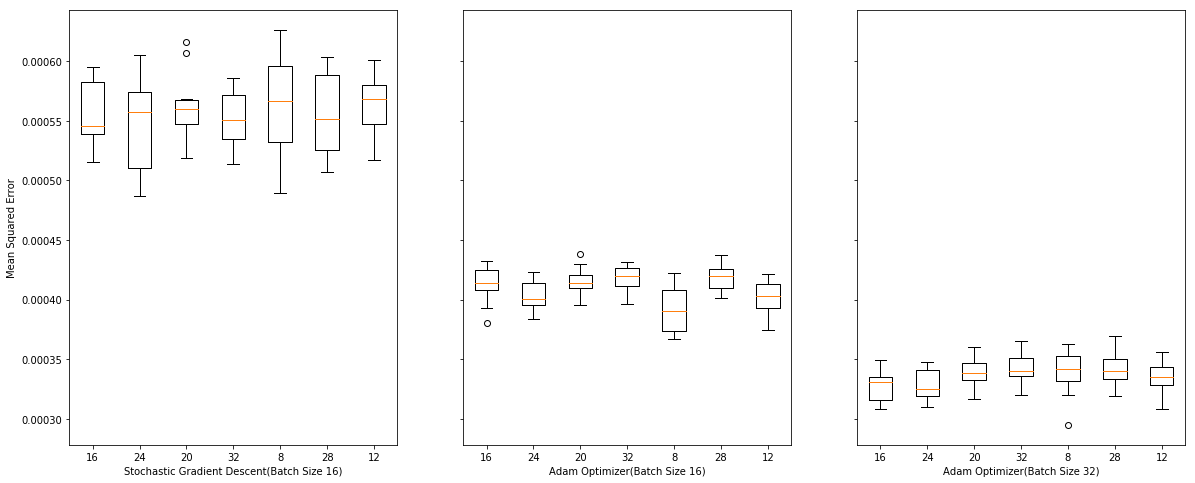

In [40]:
fig, ax = plt.subplots(1,3,figsize=(20,8),sharey=True)
ax[0].boxplot(item_model_loss.values(),labels=item_model_loss.keys())
ax[1].boxplot(item_model_loss1.values(),labels=item_model_loss1.keys())
ax[2].boxplot(item_model_loss2.values(),labels=item_model_loss2.keys())
ax[0].set_ylabel("Mean Squared Error")
ax[0].set_xlabel("Stochastic Gradient Descent(Batch Size 16)")
ax[1].set_xlabel("Adam Optimizer(Batch Size 16)")
ax[2].set_xlabel("Adam Optimizer(Batch Size 32)");

In [48]:
with open(r"item_model_val_sub1.p", "rb") as input_file:
    all_models_val_loss_p= pickle.load(input_file)

In [58]:
time_list=[]
for y in range(10):
    min_arg=np.argmin([np.mean(all_models_val_loss_p[16][y][i]) for i in range(len(all_models_val_loss_p[16][y]))])
    time_list.append(np.cumsum([sum(all_models_val_loss[16][y][i]) for i in range(len(all_models_val_loss[16][y]))][:min_arg])[-1])

In [62]:
np.mean(time_list)

28403.851563620567

### Final Model

In [25]:
y = torch.tensor(final_agg_data_items['unit_sales'].values.astype(np.float32))
X = torch.tensor(final_agg_data_items.drop('unit_sales', axis = 1).values.astype(np.float32)) 
dataset = TensorDataset(X,y) 

train_set, val_set = torch.utils.data.random_split(dataset, [37817, 9455])
train_loader1 = DataLoader(dataset = train_set, shuffle = True,batch_size=32)

validation_loader1=DataLoader(dataset = val_set, shuffle = True,batch_size=9455)

for i,j in validation_loader1:
    X_test1,y_test1=i,j

In [27]:
class FirstNetwork_final(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(59,16)
        self.lin2 = nn.Linear(16, 1)
    
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.relu()
        a2 = self.lin2(h1)
        return a2,a1

In [28]:
model1=FirstNetwork_final()

In [29]:
criterion1 = nn.MSELoss()

training_loss_model1=[]
validation_loss_model1=[]

epochs = 40
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)

for epoch in range(epochs):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1= criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

0
Training Loss: 0.0004192280644496836
Validation Loss: 0.0003552512594477223
10
Training Loss: 0.0002494790591755051
Validation Loss: 0.00021582225935656558
20
Training Loss: 0.0002544169708983287
Validation Loss: 0.00022931470001485142
30
Training Loss: 0.0002698412232816174
Validation Loss: 0.0002281149790103054


In [30]:
for epoch in range(40,80):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1= criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

40
Training Loss: 0.00026867224403515734
Validation Loss: 0.00023864384614720677
50
Training Loss: 0.0002611137959723525
Validation Loss: 0.00023553600391641326
60
Training Loss: 0.00027825560244989795
Validation Loss: 0.0002473072876479885
70
Training Loss: 0.0002742458388227736
Validation Loss: 0.00024237371366319377


In [31]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
for epoch in range(80,120):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1= criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

80
Training Loss: 0.0002327643268704832
Validation Loss: 0.00020269614195184428
90
Training Loss: 0.00022921912926474687
Validation Loss: 0.00019655229317982857
100
Training Loss: 0.00023006050573305044
Validation Loss: 0.00019810156316702078
110
Training Loss: 0.00022918316816856365
Validation Loss: 0.00019713200570599062


In [32]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
for epoch in range(120,160):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1= criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

120
Training Loss: 0.0002288852740606173
Validation Loss: 0.0001956799971622292
130
Training Loss: 0.00022952499704893706
Validation Loss: 0.0001964997159036045
140
Training Loss: 0.00022873267439108946
Validation Loss: 0.000196079515254987
150
Training Loss: 0.00022866616765238629
Validation Loss: 0.00019667682636512662


In [33]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
for epoch in range(160,200):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1= criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

160
Training Loss: 0.00022449658524538603
Validation Loss: 0.0001919164319780526
170
Training Loss: 0.00022382415581498897
Validation Loss: 0.00019153068674367406
180
Training Loss: 0.00022375873782185177
Validation Loss: 0.00019171667716059323
190
Training Loss: 0.00022388341147291254
Validation Loss: 0.00019146908469464276


In [34]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
for epoch in range(200,240):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1= criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

200
Training Loss: 0.00022393588710617858
Validation Loss: 0.0001914098133404334
210
Training Loss: 0.00022405110575323423
Validation Loss: 0.00019146792121854406
220
Training Loss: 0.00022393179557959948
Validation Loss: 0.00019145374093116095
230
Training Loss: 0.00022387686475923037
Validation Loss: 0.00019147425301293424


In [35]:
torch.save(model1.state_dict(), "items_model_final.pt")